In [1]:
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle
import training_tools
import evaluation_tools

from keras.models import Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda, Add
from keras.layers import Dropout, Activation, Concatenate, MaxPooling1D, AveragePooling1D, Flatten
from keras import layers
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))
/home/kal/K27act_models/bin/atacseq.py:280: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


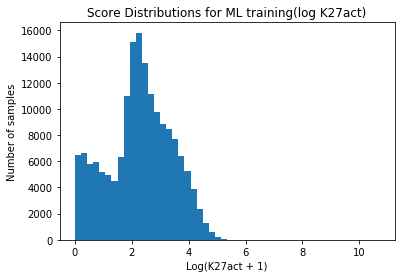

In [2]:
# load in data

#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac k27act nucs'.split() 
peaks['score'] = np.log(peaks['k27act'] + 1)

# make a histogram of score
plt.hist(peaks['score'], bins=50)
plt.title('Score Distributions for ML training(log K27act)')
plt.ylabel('Number of samples')
plt.xlabel('Log(K27act + 1)')
plt.show()

In [3]:
def make_better_residual(get_grads=False, atac_only=False, seq_only=False, batch_size=32, args=[]):
    # model's input
    if atac_only:
         seqs = Input(batch_shape=(batch_size, 1024, 1), name='input_seqs')
    elif seq_only:
        seqs = Input(batch_shape=(batch_size, 1024, 4), name='input_seqs')
    else:
        seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
    num_outputs=1

    #build custom functions
    def add_RC(x):
        if atac_only:
            RC = x[:, ::-1, ::-1]
        elif seq_only:
             RC = x[:, ::-1, ::-1]
        else:
            RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][:, :, ::-1]], axis=2)
        return K.concatenate([x, RC], axis=0)
    def add_RC_shape(s):
        return 2*s[0], s[1], s[2]

    # add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
    add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
    conv = Conv1D(256, 16, name='conv_in', padding='same', activation='relu')(add_rc(seqs))
    conv_dropped = Dropout(0.2, name='dropout')(conv)
    fr_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(conv_dropped)
    
    # increased computation
    conv2 = Conv1D(128, 3, name='conv2', padding='same', activation='relu')
    drop2 = Dropout(0.2)
    ds2 = AveragePooling1D(4)
    out2 = ds2(drop2(conv2(fr_conv)))
    
    conv3 = Conv1D(128, 3, name='conv3', padding='same', activation='relu')
    drop3 = Dropout(0.2)
    ds3 = AveragePooling1D(4)
    
    out_conv = ds3(Add()([drop3(conv3(out2)), out2])) 
    
    # we want to get an 'activation amount' for each pwm
    acts = MaxPooling1D(pool_size=64, name='pool')(out_conv)
    predictions = Flatten()(Dense(num_outputs, name='linear_combination')(acts))
    
    # build the model
    model = Model(inputs=seqs, outputs=predictions)
    model.summary()
    if get_grads:
        grads = K.gradients(predictions, seqs)[0]
        return model, grads
    return model

In [5]:
def make_better_pwm(get_grads=False, atac_only=False, seq_only=False, batch_size=32, args=[]):
    # model's input
    num_blocks = args[0]
    if atac_only:
         seqs = Input(batch_shape=(batch_size, 1024, 1), name='input_seqs')
    elif seq_only:
        seqs = Input(batch_shape=(batch_size, 1024, 4), name='input_seqs')
    else:
        seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
    num_outputs=1

    #build custom functions
    def add_RC(x):
        if atac_only:
            RC = x[:, ::-1, ::-1]
        elif seq_only:
             RC = x[:, ::-1, ::-1]
        else:
            RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][:, :, ::-1]], axis=2)
        return K.concatenate([x, RC], axis=0)
    def add_RC_shape(s):
        return 2*s[0], s[1], s[2]

    # add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
    add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
    conv = Conv1D(256, 16, name='conv_in', padding='same', activation='relu')(add_rc(seqs))
    conv_dropped = Dropout(0.2, name='dropout')(conv)
    out_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(conv_dropped)
    
    # increased computation
    for i in range(num_blocks):
        out_conv = Conv1D(128, 3, name='conv' + str(i), padding='same', activation='relu')(out_conv)
        out_conv = Dropout(0.2)(out_conv)
        out_conv = AveragePooling1D(4)(out_conv)
       
    # we want to get an 'activation amount' for each pwm
    acts = MaxPooling1D(pool_size=1024//(4**num_blocks), name='pool')(out_conv)
    predictions = Flatten()(Dense(num_outputs, name='linear_combination')(acts))
    
    # build the model
    model = Model(inputs=seqs, outputs=predictions)
    model.summary()
    if get_grads:
        grads = K.gradients(predictions, seqs)[0]
        return model, grads
    return model

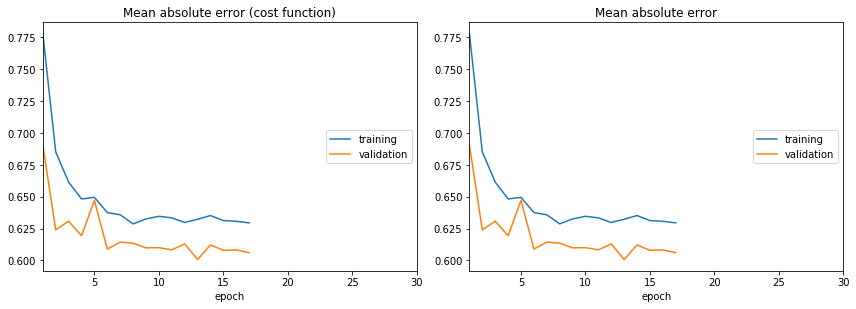

Epoch 18/30


In [ ]:
out_dir = '/home/kal/K27act_models/residual_models/'

# initial models to test

out_0 = training_tools.train_model(out_dir, make_better_pwm, peaks, 'conv0', patience=3, args=[0])
out_1 = training_tools.train_model(out_dir, make_better_pwm, peaks, 'conv1', patience=3, args=[1])
out_2 = training_tools.train_model(out_dir, make_better_pwm, peaks, 'conv2', patience=3, args=[2])
out_3 = training_tools.train_model(out_dir, make_better_pwm, peaks, 'conv3', patience=3, args=[3])
out_4 = training_tools.train_model(out_dir, make_better_pwm, peaks, 'conv4', patience=3, args=[4])
out_5 = training_tools.train_model(out_dir, make_better_pwm, peaks, 'conv5', patience=3, args=[5])

In [ ]:
# look at loss
losses = pickle.load(open(os.path.join(out_path, 'history/history.pk'), 'rb'))

plt.plot(losses['val_loss'], label='validation')
plt.plot(losses['loss'], label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.legend()
plt.show()

In [ ]:
# get test set
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed'
test_peaks = pd.read_table(peaks_path)
test_peaks['score'] = np.nan

test_peaks = test_peaks[(test_peaks.chr == 'chr8') & (test_peaks.index%2 == 1)]
cutoff = len(test_peaks)//32
test_peaks=test_peaks[:cutoff*32]
print(len(test_peaks))

In [ ]:
from keras.losses import mae

base = {'Regression':pickle.load(open('/home/kal/K27act_models/regression_models/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}
# keras models
custom_dict = {'loss_with_grad':mae, 'grad_penalty':mae}
save_dirs={'PWM': '/home/kal/K27act_models/pwm_models/20180803_164937_mae_loss/', 
          'Orig Convolution': '/home/kal/K27act_models/residual_models/20180806_152523_simple_conv/', 
          '0 Convs': out_0, '1 Conv': out_1, '2 Convs': out_2, '3 Convs': out_3, '4 Convs': out_4, 
           '5 Convs': out_5}
for i in range(5):
mls={}
for key in save_dirs:
    mls[key] = load_model(os.path.join(save_dirs[key], 'final_model.h5'), custom_objects=custom_dict)

In [ ]:
d = evaluation_tools.compare_models(test_peaks, kbaselines=base, logkmls=mls, save_dir=save_dirs)

In [ ]:
# model's input
from keras.losses import mae

batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
num_outputs=1

#build custom functions
def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

# add the rc
add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)

# do a series of convolutions and max pools

#first convolution is on seqs and reverse complements with dense downsampling
conv1 = Conv1D(256, 9, activation=None, name='conv1', padding='same')
fr_comb = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))
conv_drop1 = SpatialDropout1D(0.1, name='conv_drop1')
ds1 = MaxPooling1D(pool_size=4, name='downsample1')
down_conv = Conv1D(128, 1, activation='relu', name='downsample_features')
conv1_seqs = down(conv_drop1(fr_comb(conv1(add_rc(seqs)))))
# second convolution
conv2 = Conv1D(128, 5, activation='relu', name='conv2', padding='same')
conv_drop2 = SpatialDropout1D(0.1, name='conv_drop2')
ds2 = MaxPooling1D(pool_size=4, name='downsample2')                          
conv2_seqs = layers.add([ds1(conv1_seqs), conv_drop2(conv2(ds1(conv1_seqs)))])
# third convolution
conv3 = Conv1D(128, 5, activation='relu', name='conv3', padding='same')
conv_drop3 = SpatialDropout1D(0.1, name='conv_drop3')
ds3 = MaxPooling1D(pool_size=4, name='downsample3')                                
conv3_seqs = layers.add([ds2(ds1(conv1_seqs)), conv_drop3(conv3(ds2(conv2_seqs)))])                                
# forth convolution                               
conv4 = Conv1D(128, 3, activation='relu', name='conv4', padding='same')
conv_drop4 = SpatialDropout1D(0.1, name='conv_drop4')                                
conv4_seqs = layers.add([ds3(ds2(ds1(conv1_seqs))), conv_drop4(conv4(ds3(conv3_seqs)))])
                                
# smooth and flatten                         
smooth = AveragePooling1D(pool_size=4, strides=4, padding='valid')
flat = Flatten()
#conv_out = flat(smooth(conv4_seqs))
conv_out = Lambda(lambda x: K.sum(x, axis=1), name='sum_seq', output_shape=lambda s: (s[0], s[2]))(conv1_seqs)

# dense layers                                 
dense1 = Dense(64, activation='relu')
drop1 = Dropout(0.2)
dense2 = Dense(1, activation='relu')

preds = dense2(drop1(dense1(conv_out)))
grads = K.gradients(preds, seqs)[0]

# build the model
model = Model(inputs=seqs, outputs=preds)

model.summary()

In [ ]:
# model's input
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
num_outputs=1

#build custom functions
def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

# add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
conv = Conv1D(256, 16, name='conv_in', padding='same', activation=None)(add_rc(seqs))
conv_dropped = SpatialDropout1D(0.1)(conv)
combined = Dense(64, activation='relu')(conv_dropped)
fr_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(combined)

#do some (limited) intermediate computation
conv1 = Conv1D(128, 3, activation='relu', name='conv4', padding='same')
conv_drop1 = SpatialDropout1D(0.1, name='conv_drop4')                                
fr_conv = layers.add([fr_conv, conv_drop1(conv1(fr_conv))])

# then use a dense to get one 'k27ness' per input base
per_base = Dense(num_outputs)(fr_conv)
# sum the k27ness and take the max of forward or reverse
preds = Lambda(lambda x: K.sum(x, axis=1), name='sum_seq', 
                     output_shape=lambda s: (s[0], 1))(per_base)

grads = K.gradients(preds, seqs)[0]

# build the model
model = Model(inputs=seqs, outputs=preds)

model.summary()

In [ ]:
from keras.optimizers import RMSprop, SGD, Adam
from livelossplot import PlotLossesKeras
import lasso
import training_tools
%matplotlib inline

vpe = 10 # validations per epoch

opt = Adam(lr=1e-04)
model.compile(loss=lasso.get_lwg(grads), metrics=['mean_absolute_error', lasso.get_gp(grads)], optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-1-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
calls = [early_stop, checkpoint, PlotLossesKeras(), 
         training_tools.ChangeLR([0, 5*vpe], [1e-04, 1e-05])] 

losses = model.fit_generator(datagen.batch_gen(peaks, mode='train'), 
                             steps_per_epoch=num_training_samples//(batch_size*vpe), 
                             epochs=10*vpe, callbacks=calls, validation_data=datagen.batch_gen(peaks, mode='val'), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)
val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

In [ ]:
# look at loss
val_hist = np.asarray(val_hist).flatten()
train_hist = np.asarray(train_hist).flatten()
plt.plot(val_hist, label='validation')
plt.plot(train_hist, label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 10)
plt.legend()
plt.show()

In [ ]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

In [ ]:
# write out history
losses=dict()
losses['val_loss'] = val_hist
losses['loss'] = train_hist
pickle.dump(losses, open(os.path.join(history_path, 'history.pk'), 'wb'))

In [ ]:
# look at kernels
# make a highlight map
from colour import Color

#what layers do we have to work with?
layer_dict = dict([(layer.name, layer) for layer in model.layers]) 
print(layer_dict.keys())
this_layer='conv_in'

# plot weights from first layer neurons
#temp = .005
weight_array = layer_dict[this_layer].get_weights()[0]
#create highlight dict - with sane maxs and mins
colors = list(Color("blue").range_to(Color("white"), 50))
[colors.append(c) for c in (Color("white").range_to(Color("red"), 51))]
top = np.amax(weight_array[:, 0, :])
bottom = np.amin(weight_array[:, 0, :])
    
# got throught the kernels
for idx in range(weight_array.shape[2]):
    weight = weight_array[:,:,idx]
    #get hightlights!
    color_weights = [int((x-bottom)/(top-bottom)*100) for x in weight[:,0]]
    highlight=dict()
    for i in range(len(weight)):
        w = color_weights[i]
        highlight[(colors[w].rgb[0],colors[w].rgb[1], colors[w].rgb[2], .3)] = [(i, i+1)]
    #plot things out
    kernel = sequence.Sequence(weight[:, 1:])
    plt.figure(figsize=(20,2))
    plt.title('ATAC weights and sequence for kernel {}'.format(idx))
    plt.plot(weight[:,0])
    plt.show()
    viz_sequence.plot_weights(kernel.seq, highlight=highlight)


In [ ]:
n=2
(1024)/(4**(n))

In [ ]:
! ps aux|grep 15380